## Importaciones y Configuración Inicial

In [21]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## CARGA Y PREPARACIÓN DE DATOS

In [22]:
def load_cleaned_dataset():
    CLEANED_DATASET_PATH = "../data/processed/ddos_findef.csv"
    
    try:
        df_cleaned = pd.read_csv(CLEANED_DATASET_PATH)
        return df_cleaned
    except FileNotFoundError:
        exit()
    except Exception as e:
        exit()

# Carga y preparación de datos
df = load_cleaned_dataset()
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Flow Bytes/s,Flow Packets/s,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Idle Mean,y
0,4,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,3.000000e+06,5.000000e+05,329,0,1,20,0.0,0.0,0
1,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
2,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
3,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,1.200000e+07,2.000000e+06,329,0,1,20,0.0,0.0,0
4,3,2,0,12.0,0.0,6.0,6.0,6.000000,0.0,0.0,0.000000,4.000000e+06,6.666667e+05,245,0,1,20,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660372,196135,49,57,1331.0,105841.0,570.0,0.0,27.163265,4344.0,0.0,1856.859649,5.464196e+05,5.404441e+02,29200,61,31,20,0.0,0.0,0
2660373,378424,49,59,1325.0,104393.0,570.0,0.0,27.040816,2896.0,0.0,1769.372881,2.793639e+05,2.853942e+02,29200,61,30,20,0.0,0.0,0
2660374,161800,70,103,1427.0,215903.0,570.0,0.0,20.385714,4344.0,0.0,2096.145631,1.343201e+06,1.069221e+03,29200,61,47,20,0.0,0.0,0
2660375,142864,50,62,1331.0,110185.0,570.0,0.0,26.620000,2896.0,0.0,1777.177419,7.805745e+05,7.839624e+02,29200,61,31,20,0.0,0.0,0


In [23]:
if 'y' not in df.columns:
    print("Columna objetivo 'y' no encontrada")
    exit()

In [24]:
# Separar características y objetivo
feature_cols = [col for col in df.columns if col != 'y']
X = df[feature_cols].values
y = df['y'].values.astype(int)

print(f"Características: {X.shape[1]} variables")
print(f"Distribución de clases: {np.bincount(y)}")
print(f"   - BENIGN: {np.bincount(y)[0]:,} muestras")
print(f"   - ATTACK: {np.bincount(y)[1]:,} muestras")

Características: 19 variables
Distribución de clases: [2104911  555466]
   - BENIGN: 2,104,911 muestras
   - ATTACK: 555,466 muestras


### División y Escalado de Datos

In [25]:
# División estratificada para mantener la proporción de clases
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [26]:
# Escalado sin leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

input_dim = X_train.shape[1]

print(f"Datos divididos y escalados:")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Val:   {X_val.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")

Datos divididos y escalados:
   Train: 1,862,263 muestras
   Val:   399,057 muestras
   Test:  399,057 muestras


## LÍNEA BASE (BASELINE)

In [27]:
# Entrenamiento del modelo baseline
start_time = time.time()
baseline_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
baseline_model.fit(X_train, y_train)
train_time_base = time.time() - start_time

In [28]:
# Evaluación
start_inf = time.time()
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
inf_time_base = (time.time() - start_inf) / len(X_test)
y_pred_base = (y_prob_base >= 0.5).astype(int)

In [29]:
# Métricas
report_base = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
pr_auc_base = average_precision_score(y_test, y_prob_base)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_base)

print("Línea Base completada")
print(f"Tiempo entrenamiento: {train_time_base:.1f}s")
print(f"Latencia inferencia: {inf_time_base*1e6:.1f}µs/muestra")

Línea Base completada
Tiempo entrenamiento: 13.7s
Latencia inferencia: 0.0µs/muestra


## EXPERIMENTOS A/B (VARIANTE 1)

In [30]:
# Configuración común
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [31]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)

### VARIANTE 1: AUTOENCODER + CNN-LSTM

In [32]:
# Autoencoder
def build_autoencoder(input_dim, encoding_dim=32):
    inputs = layers.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(256, activation='relu')(inputs)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    bottleneck = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(bottleneck)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
# Entrenamiento Autoencoder
autoencoder = build_autoencoder(input_dim)
start_time = time.time()
history_ae = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, batch_size=512, 
    callbacks=[early_stop], verbose=1
)
train_time_ae = time.time() - start_time

2025-10-30 18:17:59.083459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 18:17:59.089753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 18:17:59.091993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/10


2025-10-30 18:18:03.650697: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-30 18:18:03.664767: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-10-30 18:18:03.664824: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at /home/byd-computer-ffq-u/proyects/Tesis_MIA2025-2/rtxenv/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas
2025-10-30 18:18:03.664983: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-10-30 18:18:04.183736: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-10-30 18:18:04.

3638/3638 [==============================] - 16s 3ms/step - loss: 0.3190 - val_loss: 0.0614
Epoch 2/10
3638/3638 [==============================] - 10s 3ms/step - loss: 0.2588 - val_loss: 0.1300
Epoch 3/10
3638/3638 [==============================] - 10s 3ms/step - loss: 0.1699 - val_loss: 0.0878
Epoch 4/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.1462 - val_loss: 0.3686
Epoch 5/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.5649 - val_loss: 0.0254
Epoch 6/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.1858 - val_loss: 0.1197
Epoch 7/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.2190 - val_loss: 0.1611
Epoch 8/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.2645 - val_loss: 0.1011
Epoch 9/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.1101 - val_loss: 0.2264
Epoch 10/10
3638/3638 [==============================] - 11s 3ms/step - loss: 0.2275

In [34]:
# Extracción de características
encoder = models.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Z_train = encoder.predict(X_train, verbose=1)
Z_val = encoder.predict(X_val, verbose=1)
Z_test = encoder.predict(X_test, verbose=1)

    1/58196 [..............................] - ETA: 1:14:26

2025-10-30 18:19:52.695035: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141531988 exceeds 10% of free system memory.


12471/12471 [==============================] - 9s 724us/step


In [35]:
# Preparación secuencial
def to_sequential_format(arr):
    return arr.reshape((arr.shape[0], arr.shape[1], 1))

Z_train_seq = to_sequential_format(Z_train)
Z_val_seq = to_sequential_format(Z_val)
Z_test_seq = to_sequential_format(Z_test)

In [36]:
# Modelo CNN-LSTM
def build_cnn_lstm(seq_length):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=(seq_length, 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento CNN-LSTM
cnn_lstm_model = build_cnn_lstm(Z_train_seq.shape[1])
start_time = time.time()
history_clf = cnn_lstm_model.fit(
    Z_train_seq, y_train,
    validation_data=(Z_val_seq, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_clf = time.time() - start_time

2025-10-30 18:21:32.045091: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Epoch 1/5


2025-10-30 18:21:35.839892: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-30 18:21:35.844825: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: /home/byd-computer-ffq-u/proyects/Tesis_MIA2025-2/rtxenv/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-10-30 18:21:38.171803: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-10-30 18:21:38.172833: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-10-30

3638/3638 [==============================] - 27s 5ms/step - loss: 0.1798 - accuracy: 0.9105 - val_loss: 0.1289 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 2/5
3638/3638 [==============================] - 17s 5ms/step - loss: 0.1171 - accuracy: 0.9475 - val_loss: 0.1125 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 3/5
3638/3638 [==============================] - 17s 5ms/step - loss: 0.1032 - accuracy: 0.9541 - val_loss: 0.1036 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/5
3638/3638 [==============================] - 17s 5ms/step - loss: 0.0958 - accuracy: 0.9576 - val_loss: 0.0969 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/5
3638/3638 [==============================] - 16s 4ms/step - loss: 0.0893 - accuracy: 0.9606 - val_loss: 0.0849 - val_accuracy: 0.9657 - lr: 0.0010


In [38]:
# Evaluación Variante 1
start_inf = time.time()
y_prob_var1 = cnn_lstm_model.predict(Z_test_seq, verbose=1).ravel()
inf_time_var1 = (time.time() - start_inf) / len(Z_test_seq)
y_pred_var1 = (y_prob_var1 >= 0.5).astype(int)

report_var1 = classification_report(y_test, y_pred_var1, output_dict=True, zero_division=0)
roc_auc_var1 = roc_auc_score(y_test, y_prob_var1)
pr_auc_var1 = average_precision_score(y_test, y_prob_var1)
precision_var1, recall_var1, _ = precision_recall_curve(y_test, y_prob_var1)

train_time_var1 = train_time_ae + train_time_clf

print("Variante 1 completada")
print(f"Tiempo total: {train_time_var1:.1f}s")
print(f"Latencia: {inf_time_var1*1e6:.1f}µs/muestra")

12471/12471 [==============================] - 16s 1ms/step
Variante 1 completada
Tiempo total: 205.4s
Latencia: 48.5µs/muestra


### VARIANTE 2: MULTI-LAYER PERCEPTRON (MLP)

In [39]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento MLP
mlp_model = build_mlp(input_dim)
start_time = time.time()
history_mlp = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_var2 = time.time() - start_time

Epoch 1/10
3638/3638 [==============================] - 10s 2ms/step - loss: 0.1715 - accuracy: 0.9197 - val_loss: 0.1200 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 2/10
3638/3638 [==============================] - 8s 2ms/step - loss: 0.1127 - accuracy: 0.9523 - val_loss: 0.0949 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 3/10
3638/3638 [==============================] - 8s 2ms/step - loss: 0.1015 - accuracy: 0.9590 - val_loss: 0.0838 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 4/10
3638/3638 [==============================] - 8s 2ms/step - loss: 0.0986 - accuracy: 0.9601 - val_loss: 0.0893 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 5/10
3638/3638 [==============================] - 8s 2ms/step - loss: 0.0942 - accuracy: 0.9626 - val_loss: 0.0741 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 6/10
3638/3638 [==============================] - 8s 2ms/step - loss: 0.0962 - accuracy: 0.9598 - val_loss: 0.0819 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 7/10
3638/3638 [==============================] - 8

In [41]:
# Evaluación Variante 2
start_inf = time.time()
y_prob_var2 = mlp_model.predict(X_test, verbose=1).ravel()
inf_time_var2 = (time.time() - start_inf) / len(X_test)
y_pred_var2 = (y_prob_var2 >= 0.5).astype(int)

report_var2 = classification_report(y_test, y_pred_var2, output_dict=True, zero_division=0)
roc_auc_var2 = roc_auc_score(y_test, y_prob_var2)
pr_auc_var2 = average_precision_score(y_test, y_prob_var2)
precision_var2, recall_var2, _ = precision_recall_curve(y_test, y_prob_var2)

print("Variante 2 completada")
print(f"Tiempo: {train_time_var2:.1f}s")
print(f"Latencia: {inf_time_var2*1e6:.1f}µs/muestra")

12471/12471 [==============================] - 10s 764us/step
Variante 2 completada
Tiempo: 85.8s
Latencia: 32.4µs/muestra


## RESULTADOS Y VISUALIZACIÓN

### Tabla Comparativa: Baseline vs. Variante 1

In [42]:
# Tabla comparativa
results_data = {
    'Métrica': [
        'F1-Score (ATTACK) - Principal',
        'Precision (ATTACK)',
        'Recall (ATTACK)', 
        'Accuracy',
        'PR-AUC - Secundaria',
        'ROC-AUC',
        'Tiempo Entrenamiento (s)',
        'Latencia Inferencia (µs/muestra)'
    ],
    'Línea Base (Regresión Logística)': [
        f"{report_base['1']['f1-score']:.4f}",
        f"{report_base['1']['precision']:.4f}",
        f"{report_base['1']['recall']:.4f}",
        f"{report_base['accuracy']:.4f}",
        f"{pr_auc_base:.4f}",
        f"{roc_auc_base:.4f}",
        f"{train_time_base:.1f}",
        f"{inf_time_base*1e6:.1f}"
    ],
    'Variante 1 (AE + CNN-LSTM)': [
        f"{report_var1['1']['f1-score']:.4f}",
        f"{report_var1['1']['precision']:.4f}",
        f"{report_var1['1']['recall']:.4f}",
        f"{report_var1['accuracy']:.4f}",
        f"{pr_auc_var1:.4f}",
        f"{roc_auc_var1:.4f}",
        f"{train_time_var1:.1f}",
        f"{inf_time_var1*1e6:.1f}"
    ],
    'Variante 2 (MLP)': [
        f"{report_var2['1']['f1-score']:.4f}",
        f"{report_var2['1']['precision']:.4f}",
        f"{report_var2['1']['recall']:.4f}",
        f"{report_var2['accuracy']:.4f}",
        f"{pr_auc_var2:.4f}",
        f"{roc_auc_var2:.4f}",
        f"{train_time_var2:.1f}",
        f"{inf_time_var2*1e6:.1f}"
    ]
}

df_results = pd.DataFrame(results_data)
print("\n📋 TABLA COMPARATIVA")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


📋 TABLA COMPARATIVA
                         Métrica Línea Base (Regresión Logística) Variante 1 (AE + CNN-LSTM) Variante 2 (MLP)
   F1-Score (ATTACK) - Principal                           0.6533                     0.9218           0.9202
              Precision (ATTACK)                           0.4892                     0.8712           0.8619
                 Recall (ATTACK)                           0.9829                     0.9786           0.9871
                        Accuracy                           0.7821                     0.9653           0.9643
             PR-AUC - Secundaria                           0.8229                     0.9832           0.9889
                         ROC-AUC                           0.9358                     0.9955           0.9968
        Tiempo Entrenamiento (s)                             13.7                      205.4             85.8
Latencia Inferencia (µs/muestra)                              0.0                       48.5       

### Gráfico Único: Curva Precision-Recall

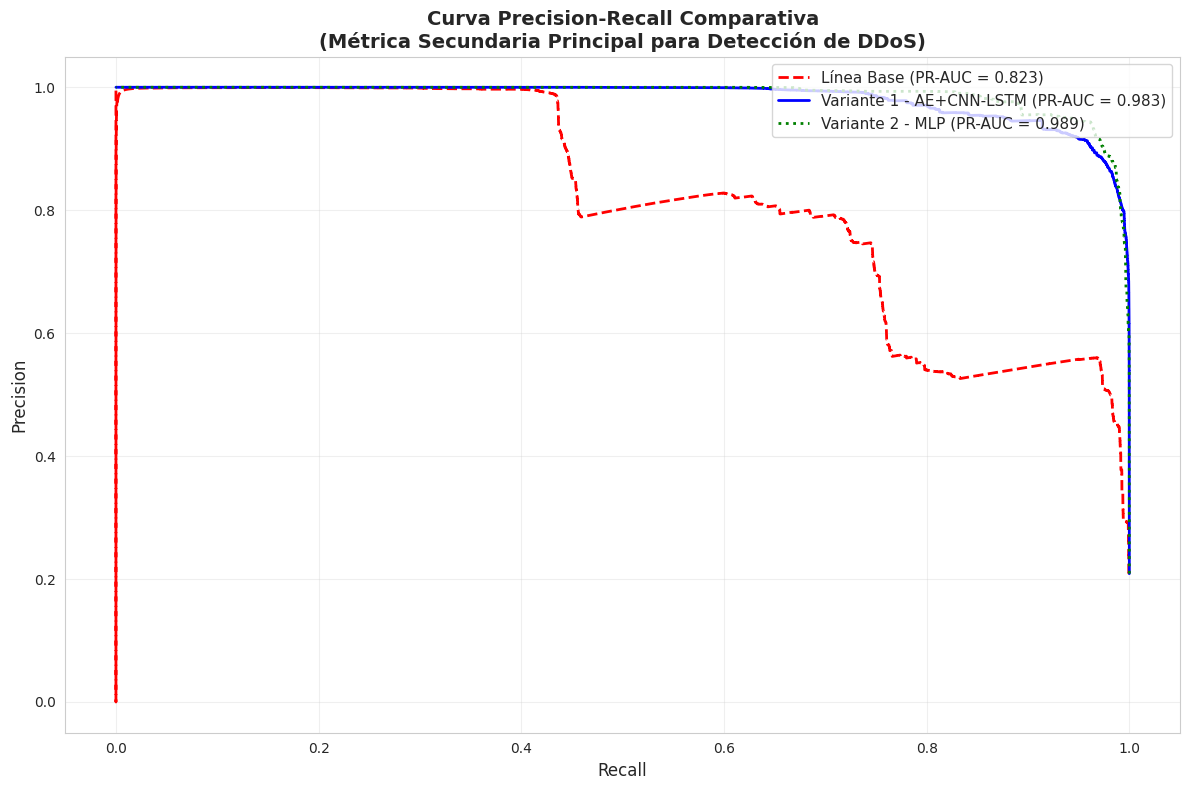

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(recall_base, precision_base, 
         label=f'Línea Base (PR-AUC = {pr_auc_base:.3f})', 
         color='red', linewidth=2, linestyle='--')
plt.plot(recall_var1, precision_var1, 
         label=f'Variante 1 - AE+CNN-LSTM (PR-AUC = {pr_auc_var1:.3f})', 
         color='blue', linewidth=2)
plt.plot(recall_var2, precision_var2, 
         label=f'Variante 2 - MLP (PR-AUC = {pr_auc_var2:.3f})', 
         color='green', linewidth=2, linestyle=':')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall Comparativa\n(Métrica Secundaria Principal para Detección de DDoS)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

TRADEOFF PRECISION-RECALL CON PUNTOS DE OPERACIÓN

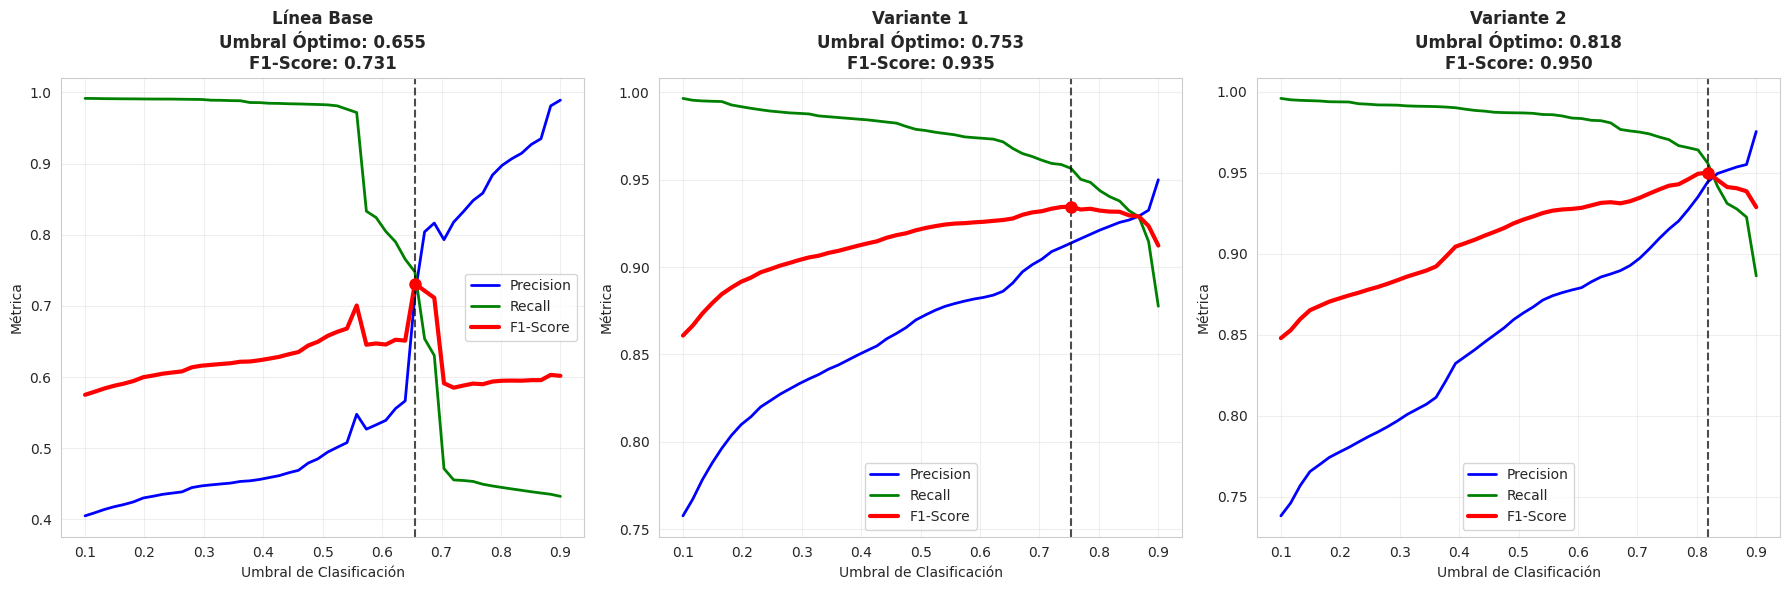

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (probs, model_name, color) in enumerate([
    (y_prob_base, 'Línea Base', 'red'),
    (y_prob_var1, 'Variante 1', 'blue'),
    (y_prob_var2, 'Variante 2', 'green')
]):
    # Calcular métricas para diferentes umbrales
    thresholds = np.linspace(0.1, 0.9, 50)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precisions.append(report['1']['precision'])
        recalls.append(report['1']['recall'])
        f1_scores.append(report['1']['f1-score'])
    
    # Encontrar umbral óptimo (max F1)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Graficar
    axes[idx].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[idx].plot(thresholds, recalls, 'g-', label='Recall', linewidth=2)
    axes[idx].plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=3)
    
    # Marcar punto óptimo
    axes[idx].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7)
    axes[idx].plot(optimal_threshold, f1_scores[optimal_idx], 'ro', markersize=8)
    
    axes[idx].set_xlabel('Umbral de Clasificación')
    axes[idx].set_ylabel('Métrica')
    axes[idx].set_title(f'{model_name}\nUmbral Óptimo: {optimal_threshold:.3f}\nF1-Score: {f1_scores[optimal_idx]:.3f}', 
                       fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

COMPARACIÓN DE DETECCIÓN TEMPRANA (Recall@K)

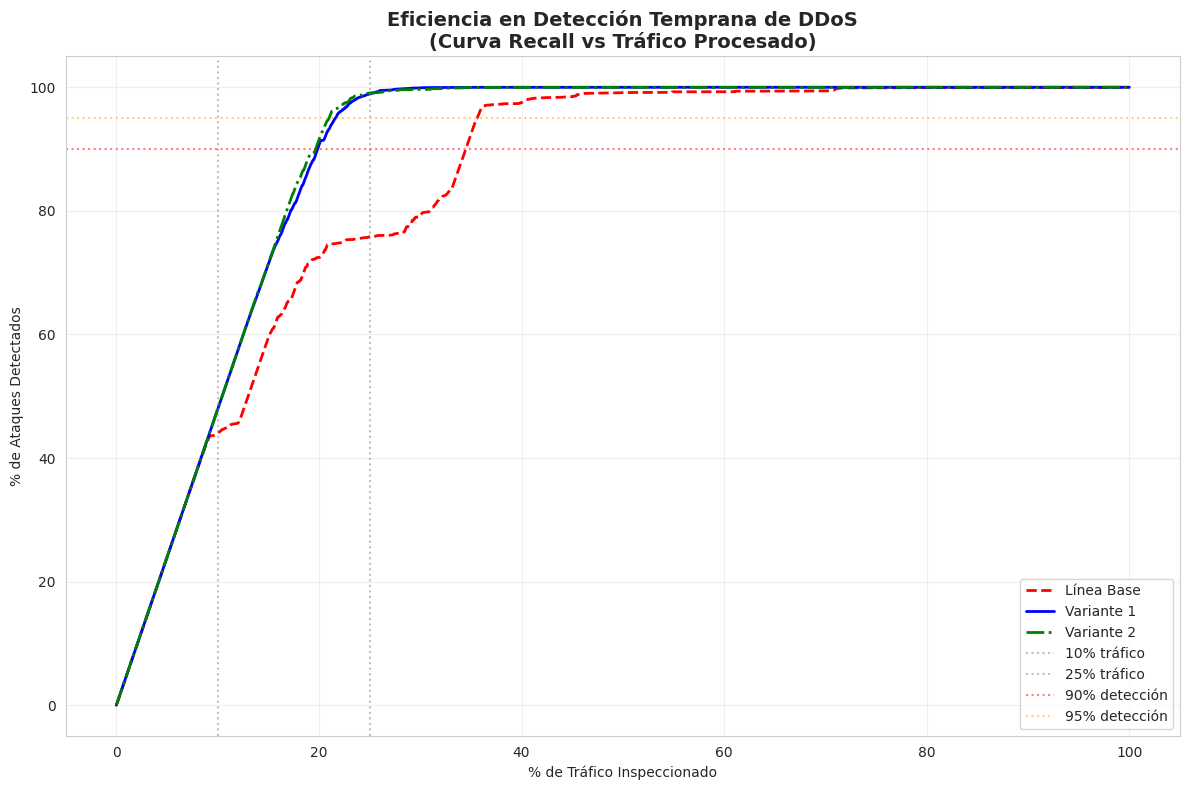

In [45]:
plt.figure(figsize=(12, 8))

for probs, model_name, color, linestyle in [
    (y_prob_base, 'Línea Base', 'red', '--'),
    (y_prob_var1, 'Variante 1', 'blue', '-'),
    (y_prob_var2, 'Variante 2', 'green', '-.')
]:
    # Ordenar muestras por probabilidad descendente
    sorted_indices = np.argsort(probs)[::-1]
    sorted_labels = y_test[sorted_indices]
    
    # Calcular recall acumulado
    cumulative_attacks = np.cumsum(sorted_labels == 1)
    total_attacks = np.sum(y_test == 1)
    recall_at_k = cumulative_attacks / total_attacks
    
    # Porcentaje de tráfico inspeccionado
    traffic_inspected = np.arange(1, len(recall_at_k) + 1) / len(recall_at_k)
    
    plt.plot(traffic_inspected * 100, recall_at_k * 100, 
             label=model_name, color=color, linestyle=linestyle, linewidth=2)

plt.xlabel('% de Tráfico Inspeccionado')
plt.ylabel('% de Ataques Detectados')
plt.title('Eficiencia en Detección Temprana de DDoS\n(Curva Recall vs Tráfico Procesado)', 
          fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Marcadores clave
plt.axvline(x=10, color='gray', linestyle=':', alpha=0.5, label='10% tráfico')
plt.axvline(x=25, color='gray', linestyle=':', alpha=0.5, label='25% tráfico')
plt.axhline(y=90, color='red', linestyle=':', alpha=0.5, label='90% detección')
plt.axhline(y=95, color='orange', linestyle=':', alpha=0.5, label='95% detección')

plt.legend()
plt.tight_layout()
plt.show()

IMPACTO DE FALSOS POSITIVOS VS FALSOS NEGATIVOS

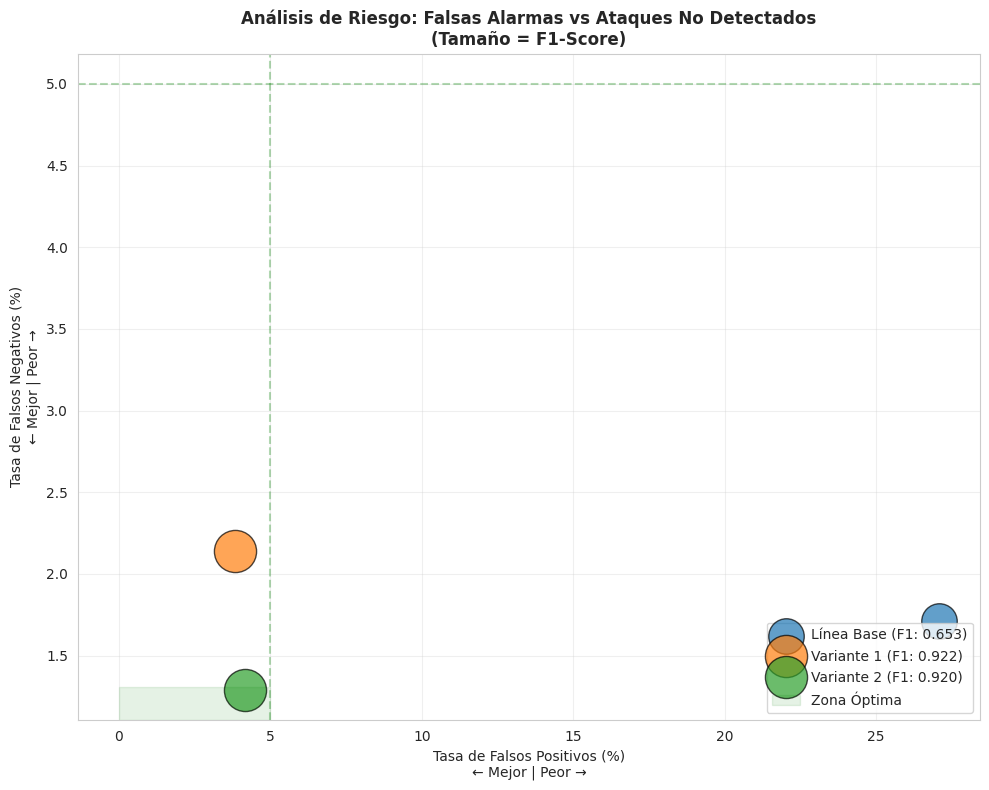

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

# Calcular FP y FN para cada modelo
fp_fn_data = []
model_names = ['Línea Base', 'Variante 1', 'Variante 2']
predictions = [y_pred_base, y_pred_var1, y_pred_var2]

for i, (y_pred, name) in enumerate(zip(predictions, model_names)):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_rate = fp / (fp + tn)  # Falsa alarma
    fn_rate = fn / (fn + tp)  # Ataque no detectado
    
    fp_fn_data.append((fp_rate, fn_rate, name))

# Scatter plot con burbujas proporcionales al F1-Score
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
sizes = [score * 1000 for score in f1_scores]  # Tamaño proporcional al F1-Score

for i, (fp_rate, fn_rate, name) in enumerate(fp_fn_data):
    ax.scatter(fp_rate * 100, fn_rate * 100, s=sizes[i], alpha=0.7, 
               label=f'{name} (F1: {f1_scores[i]:.3f})', edgecolors='black')

ax.set_xlabel('Tasa de Falsos Positivos (%)\n← Mejor | Peor →')
ax.set_ylabel('Tasa de Falsos Negativos (%)\n← Mejor | Peor →')
ax.set_title('Análisis de Riesgo: Falsas Alarmas vs Ataques No Detectados\n(Tamaño = F1-Score)', 
             fontweight='bold', fontsize=12)

# Área óptima (esquina inferior izquierda)
ax.axvspan(0, 5, ymin=0, ymax=0.05, alpha=0.1, color='green', label='Zona Óptima')
ax.axhline(y=5, color='green', linestyle='--', alpha=0.3)
ax.axvline(x=5, color='green', linestyle='--', alpha=0.3)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ENDIMIENTO VS EFICIENCIA

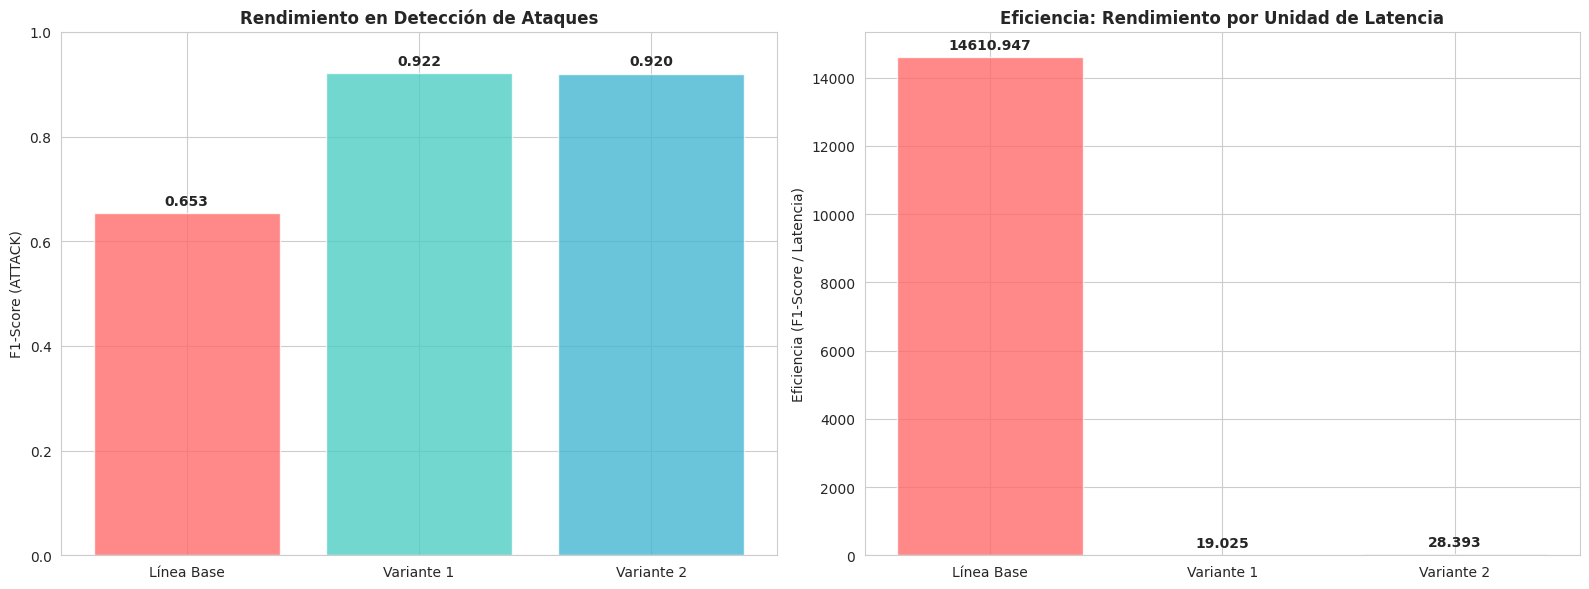

In [47]:
# Crear métrica compuesta (F1-Score normalizado por latencia)
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
latencies = [inf_time_base * 1000, inf_time_var1 * 1000, inf_time_var2 * 1000]  # ms
efficiency_scores = [f1 / lat for f1, lat in zip(f1_scores, latencies)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Rendimiento puro
bars1 = ax1.bar(model_names, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax1.set_ylabel('F1-Score (ATTACK)')
ax1.set_title('Rendimiento en Detección de Ataques', fontweight='bold')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Eficiencia (rendimiento/latencia)
bars2 = ax2.bar(model_names, efficiency_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax2.set_ylabel('Eficiencia (F1-Score / Latencia)')
ax2.set_title('Eficiencia: Rendimiento por Unidad de Latencia', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(efficiency_scores)*0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

ANÁLISIS DE CONFIANZA EN LAS PREDICCIONES

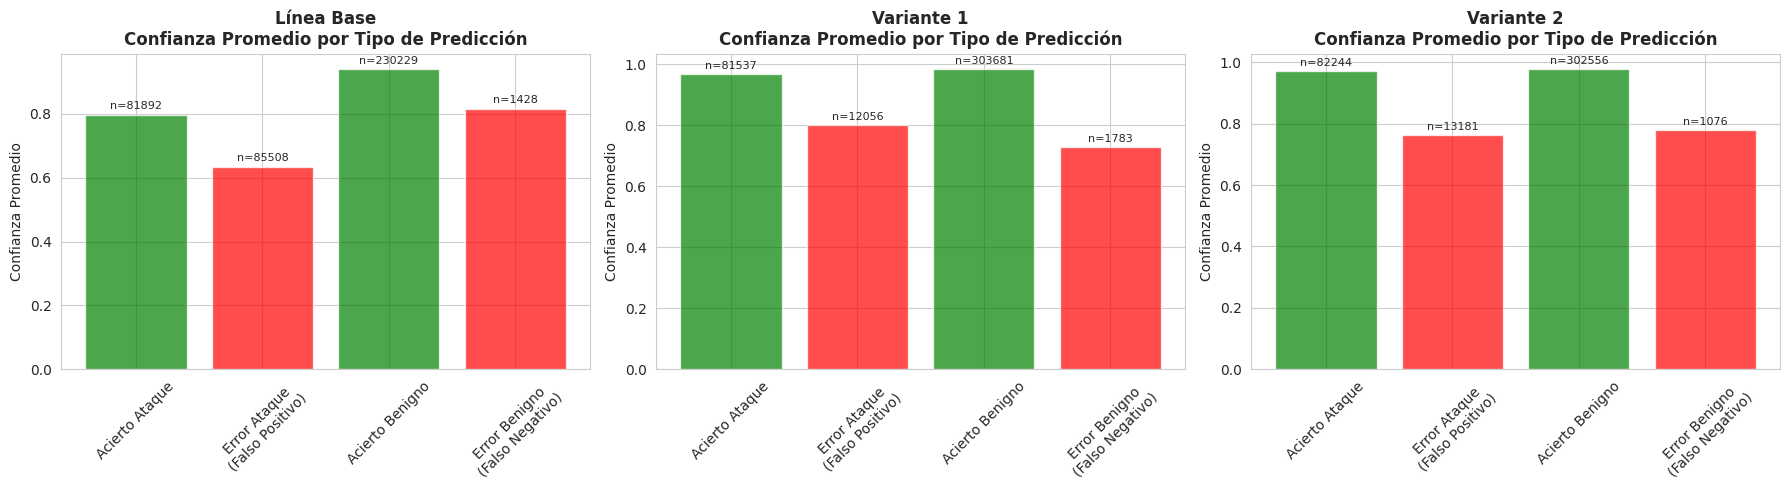

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (probs, preds, model_name) in enumerate([
    (y_prob_base, y_pred_base, 'Línea Base'),
    (y_prob_var1, y_pred_var1, 'Variante 1'),
    (y_prob_var2, y_pred_var2, 'Variante 2')
]):
    # Calcular confianza promedio por tipo de predicción
    correct_attack = probs[(y_test == 1) & (preds == 1)]
    incorrect_attack = probs[(y_test == 0) & (preds == 1)]
    correct_benign = 1 - probs[(y_test == 0) & (preds == 0)]
    incorrect_benign = 1 - probs[(y_test == 1) & (preds == 0)]
    
    categories = ['Acierto Ataque', 'Error Ataque\n(Falso Positivo)', 
                  'Acierto Benigno', 'Error Benigno\n(Falso Negativo)']
    confidences = [
        np.mean(correct_attack) if len(correct_attack) > 0 else 0,
        np.mean(incorrect_attack) if len(incorrect_attack) > 0 else 0,
        np.mean(correct_benign) if len(correct_benign) > 0 else 0,
        np.mean(incorrect_benign) if len(incorrect_benign) > 0 else 0
    ]
    counts = [len(correct_attack), len(incorrect_attack), 
              len(correct_benign), len(incorrect_benign)]
    
    bars = axes[idx].bar(categories, confidences, color=['green', 'red', 'green', 'red'], alpha=0.7)
    axes[idx].set_title(f'{model_name}\nConfianza Promedio por Tipo de Predicción', fontweight='bold')
    axes[idx].set_ylabel('Confianza Promedio')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Añadir conteos
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Matriz de Decisión

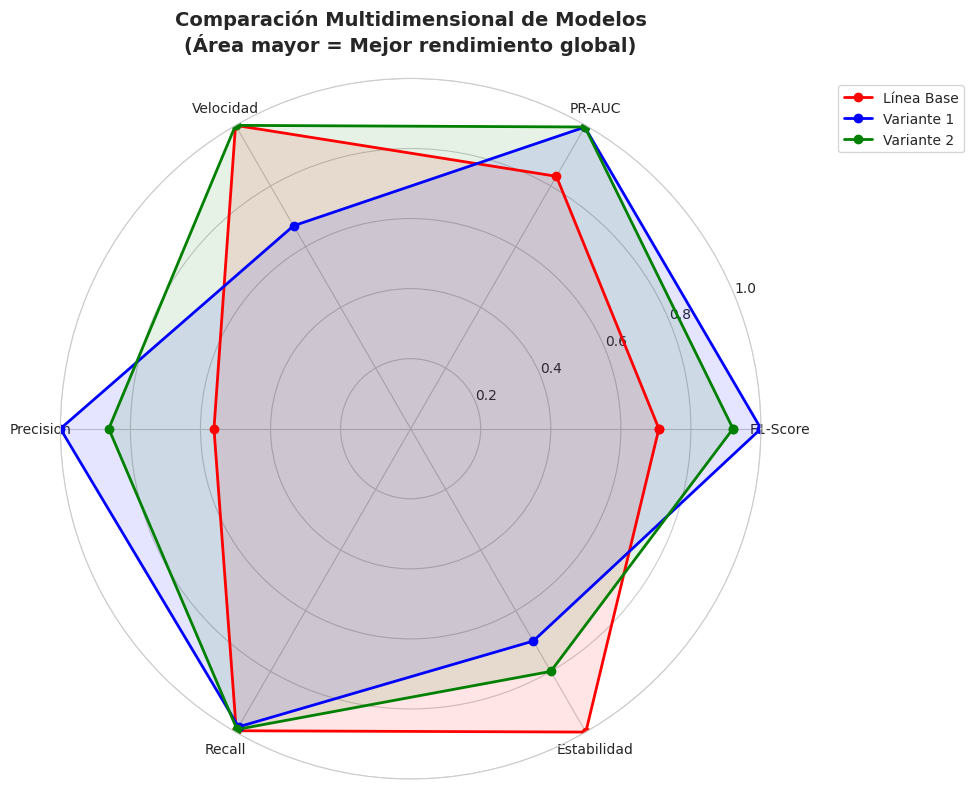

In [49]:
criteria = ['F1-Score', 'PR-AUC', 'Velocidad', 'Precision', 'Recall', 'Estabilidad']
models_data = {
    'Línea Base': [f1_scores[0], pr_auc_base, 1/latencies[0], 
                   report_base['1']['precision'], report_base['1']['recall'], 0.9],
    'Variante 1': [f1_scores[1], pr_auc_var1, 1/latencies[1],
                   report_var1['1']['precision'], report_var1['1']['recall'], 0.7],
    'Variante 2': [f1_scores[2], pr_auc_var2, 1/latencies[2],
                   report_var2['1']['precision'], report_var2['1']['recall'], 0.8]
}

# Normalizar datos (0-1)
for key in models_data:
    models_data[key] = [x / max([models_data[m][i] for m in models_data]) 
                       for i, x in enumerate(models_data[key])]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

for model_name, color in [('Línea Base', 'red'), ('Variante 1', 'blue'), ('Variante 2', 'green')]:
    values = models_data[model_name]
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(criteria)
ax.set_ylim(0, 1)
ax.set_title('Comparación Multidimensional de Modelos\n(Área mayor = Mejor rendimiento global)', 
             fontweight='bold', fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

## 5. Validación y Sanidad
- **Split Estratificado:** Proporción de clases mantenida
- **Sin Leakage:** Scaler ajustado solo con training
- **Seeds Fijos:** random_state=42 para reproducibilidad
- **Evaluación Consistente:** Mismas métricas para todos

## 6. Conclusión y Decisión

In [50]:
f1_scores = {
    'Línea Base': report_base['1']['f1-score'],
    'Variante 1': report_var1['1']['f1-score'], 
    'Variante 2': report_var2['1']['f1-score']
}

best_model_name = max(f1_scores, key=f1_scores.get)

## 7. Reproducibilidad

In [51]:
# Guardar artefactos
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

print(f"\nGUARDANDO ARTEFACTOS EN: {checkpoint_dir.absolute()}")

# Guardar scaler y modelo seleccionado
joblib.dump(scaler, checkpoint_dir / "scaler.pkl")

if best_model_name == 'Variante 1':
    encoder.save(checkpoint_dir / "encoder.keras")
    cnn_lstm_model.save(checkpoint_dir / "classifier.keras")
    print("Autoencoder + CNN-LSTM guardado")
elif best_model_name == 'Variante 2':
    mlp_model.save(checkpoint_dir / "mlp_classifier.keras")
    print("MLP guardado")
else:
    joblib.dump(baseline_model, checkpoint_dir / "logistic_regression.pkl")
    print("Regresión Logística guardada")

# Guardar resultados
df_results.to_csv(checkpoint_dir / "model_comparison_results.csv", index=False)
print("Resultados comparativos guardados")

print(f"\nESTRUCTURA DE ARTEFACTOS:")
for file in checkpoint_dir.glob("*"):
    print(f"   • {file.name}")


GUARDANDO ARTEFACTOS EN: /home/byd-computer-ffq-u/proyects/Tesis_MIA2025-2/notebooks/checkpoints
Autoencoder + CNN-LSTM guardado
Resultados comparativos guardados

ESTRUCTURA DE ARTEFACTOS:
   • encoder.keras
   • scaler.pkl
   • model_comparison_results.csv
   • mlp_classifier.keras
   • classifier.keras



- **Comandos para Correr (README):**
    1.  Asegurarse de tener el dataset `dataset_final.csv` en la carpeta `../dataset/`.
    2.  Instalar las dependencias (`pip install -r requirements.txt`).
    3.  Ejecutar este script o notebook.

**Ubicación de Artefactos:** Los modelos finales y el scaler se guardan en la carpeta `./checkpoints/`.